# Praca domowa nr 2

In [527]:
import numpy as np
import time
from PIL import Image
from copy import deepcopy

Na początek wczytujemy nasze zdjęcie, będziemy pracować na nim w formacie czarno-białym oraz RGB.

RGB; (287, 162)


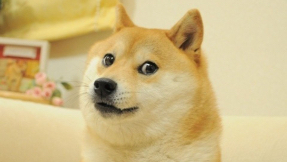

L; (287, 162)


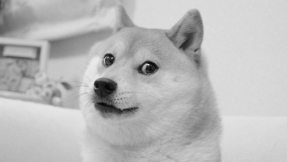

In [528]:
img = Image.open('doge.jpg')
imgL = img.convert('L')
print(img.mode, '; ', img.size, sep='')
display(img)
print(imgL.mode, '; ', imgL.size, sep='')
display(imgL)

## Przesuwanie filtru wzdłuż obrazka

In [529]:
M_img = np.asarray(img)
M_imgL = np.asarray(imgL)

Aby początkowo uprościć zadanie stworzymy funkcję, która będzie działała dla obrazka czarno-białego, następnie będziemy ją "ulepszać".
Wyświetlmy jak wygląda nasza macierz w przypadku obrazka czarno-białego:

In [530]:
print(M_imgL)

[[ 77  96 113 ... 211 210 209]
 [ 74  93 108 ... 212 211 210]
 [ 69  92  99 ... 213 211 210]
 ...
 [180 179 179 ... 205 205 205]
 [180 180 178 ... 202 203 202]
 [178 175 177 ... 203 203 202]]


In [531]:
def conv_L(image, kernels, stride = [1, 1]):
    # One kernel is a matrix n x n where n is an odd number
    # Stride[0] - vertical step
    # Stride[1] - horizontal step
    
    def __conv_L(image, kernel, stride):
        
        width, height = image.size
        image = np.asarray(image)
        new_image = deepcopy(image)
        kernel_size = len(kernel)
        p = kernel_size//2

        for y in range(p+1, height-p, stride[0]):
            for x in range(p+1, width-p, stride[1]):
                new_image[y//stride[0]][x//stride[1]] = np.sum(image[y-p:y+p+1, x-p:x+p+1] * kernel)
                
        new_image = new_image[p:height//stride[0], p:width//stride[1]]
        return Image.fromarray(new_image.astype('uint8'), 'L')
    
    if type(kernels[0][0]) != list:
        kernels = [kernels]
    
    new_image = deepcopy(image)
    
    for kernel in kernels:
        new_image = __conv_L(new_image, kernel, stride)
    
    return new_image

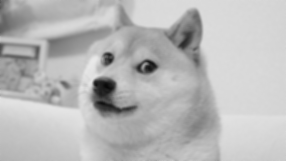

In [532]:
box_blur = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]) / 9
conv_L(imgL, box_blur)

Zastosowaliśmy na naszym obrazku efekt "rozmazywania".
Sprawdźmy jeszcze jak zachowa się nasz obrazek przy zmianie parametru stride:

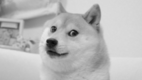

In [533]:
conv_L(imgL, box_blur, stride = [2, 2])

Teraz rozszerzymy napisaną funkcję do obrazków kolorwych (RGB).

In [534]:
def conv(image, kernels, stride = [1, 1]):
    
    def __conv(image, kernels, stride = [1, 1]):
    
        if len(kernels.shape) < 3:
            kernels = np.array([kernels])
        if kernels.shape[0] < 3:
            kernels = np.tile(kernels, [3, 1, 1])

        width, height = image.size
        image = np.asarray(image)
        new_image = deepcopy(image)

        for i in range(3):
            kernel_size = len(kernels[i])
            p = kernel_size//2
            for y in range(p+1, height-p, stride[0]):
                for x in range(p+1, width-p, stride[1]):
                    new_image[y//stride[0]][x//stride[1]][i] = np.sum(image[:,:,i][y-p:y+p+1, x-p:x+p+1] * kernels[i])

        new_image = new_image[:height//stride[0], :width//stride[1], :]
        return Image.fromarray(new_image.astype('uint8'))
    
    if len(np.asarray(image).shape) == 2:
        return conv_L(image, kernels, stride)
        
    else:
        return __conv(image, kernels, stride)

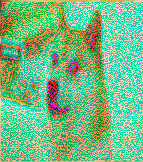

In [535]:
edge_detection = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
sharpen = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
# możemy wykorzystać trzy różne filtry (po jednym na każdą warstwę z kolorów (R, G, B)) i zmienić stride na [1, 2]
conv(img, np.array([edge_detection, box_blur, sharpen]), [1, 2])

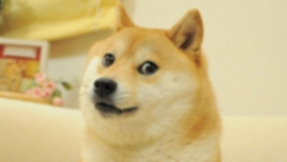

In [536]:
# Gdy użyjemy jednego filtru na kolorowym obrazku to będzie on zastosowany na wszystkie warstwy kolorów
conv(img, box_blur)

## Mnożenie macierzy

Tym razem ograniczamy się jedynie do obrazów czarno-białych i przyjmiemy, że stride = [1, 1].
Dalej zakładamy, że nasz filtr (kernel) jest kwadratowy o nieparzystej liczbie wierszy.

In [537]:
def im2col(mtx, kernel):
    kernel_size = len(kernel)

    height, width = mtx.shape
    new_h = height - kernel_size + 1
    new_w = width - kernel_size + 1
    col = np.zeros([new_h * new_w, kernel_size ** 2])

    for i in range(new_h):
        for j in range(new_w):
            patch = mtx[..., i:i+kernel_size, j:j+kernel_size]
            col[i * new_w + j, :] = np.reshape(patch, -1)
    return col

In [538]:
def conv2(image, kernels):
    
    if len(kernels.shape) == 2:
        kernels = np.array([kernels])
    
    def __conv2(image, kernel):
        mtx = np.asarray(image)

        kernel_size = len(kernel)
        height, width = mtx.shape
        new_h = height - kernel_size + 1
        new_w = width - kernel_size + 1

        new_image = kernel.flatten() @ np.transpose(im2col(mtx, kernel))

        new_image = new_image.reshape(new_h, new_w)

        return Image.fromarray(new_image.astype('uint8'), 'L')
    
    new_image = deepcopy(image)
    
    for kernel in kernels:
        new_image = __conv2(new_image, kernel)
    
    return new_image

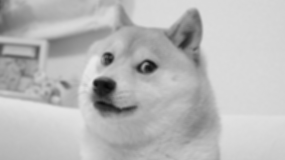

In [539]:
conv2(imgL, box_blur)

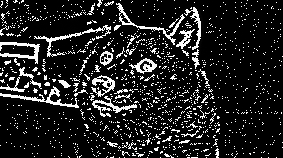

In [540]:
kernels = np.array([box_blur, edge_detection/3])
conv2(imgL, kernels)

## Porównanie czasów wykonywania

Weźmiemy nasz początkowy obraz doge czarno-biały i sprawdziwmy, która z funkcji działa szybciej i jak bardzo.

In [541]:
# użyjemy trochę większego obrazka, żeby uzyskać lepiej odwzorowane czasy
doge = Image.open('doge2.jpg')
doge = doge.convert('L')
gaussian_blur = np.array([[1, 4, 6, 4, 1], [4, 16, 24, 16, 4], [6, 24, 36, 24, 6],
                         [4, 16, 24, 16, 4], [1, 4, 6, 4, 1]]) / 256

In [542]:
start = time.time()
c_1 = conv(doge, gaussian_blur)
print(time.time() - start, 's', sep='')

start = time.time()
c_2 = conv2(doge, gaussian_blur)
print(time.time() - start, 's', sep='')

5.9238667488098145s
2.206747055053711s


Porównajmy jeszcze, czy na pewno dostaliśmy takie same obrazy:

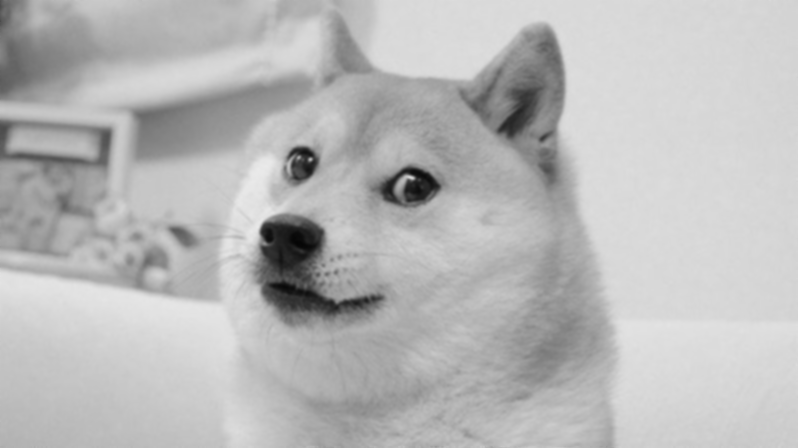

In [543]:
c_1

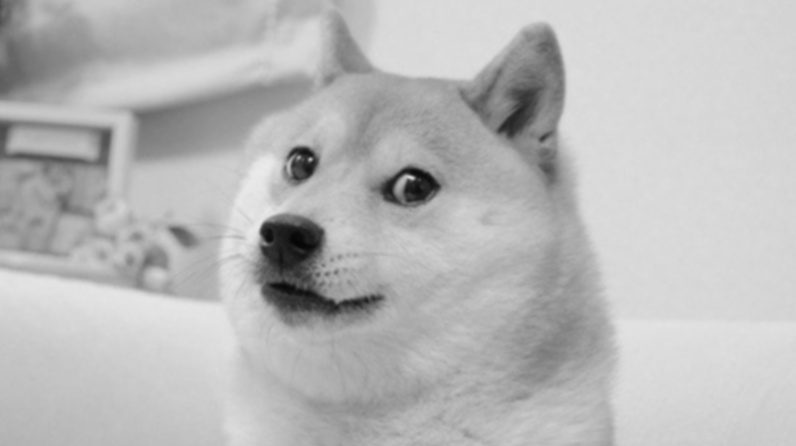

In [544]:
c_2

## Wnioski

Widać, że funkcja z użyciem mnożenia macierzy jest zauważalnie szybsza nawet przy jednorazowym użyciu. Ma to ogromne znaczenie, gdybyśmy przez taką funkcję musieli przepuścić większą liczbę obrazów.
Szybkość drugiej funkcji spowodowana jest zwektoryzowanym pakietem numpy, który jest znacznie szybszy od pythonowych pętli.